# Principal Component Analysis

- Reducing high-dimensional data to two or three dimensions so that it can be plotted and explored
- Reducing the number of dimensions in a dataset and then restoring the original number of dimensions, which finds application in anomaly detection and noise filtering
- Anonymizing datasets so that they can be shared with others without revealing the nature or meaning of the data

#### A logical question to ask is, what is the “right” number of components? In other words, what number of components strikes the best balance between reducing the number of dimensions in the dataset and retaining most of the information? One way to find that number is with a scree plot, which charts the proportion of explained variance for each dimension. The following code produces a scree plot for the PCA transform used on the facial images:

In [ ]:

import seaborn as sns
sns.set()

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

import numpy as np

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

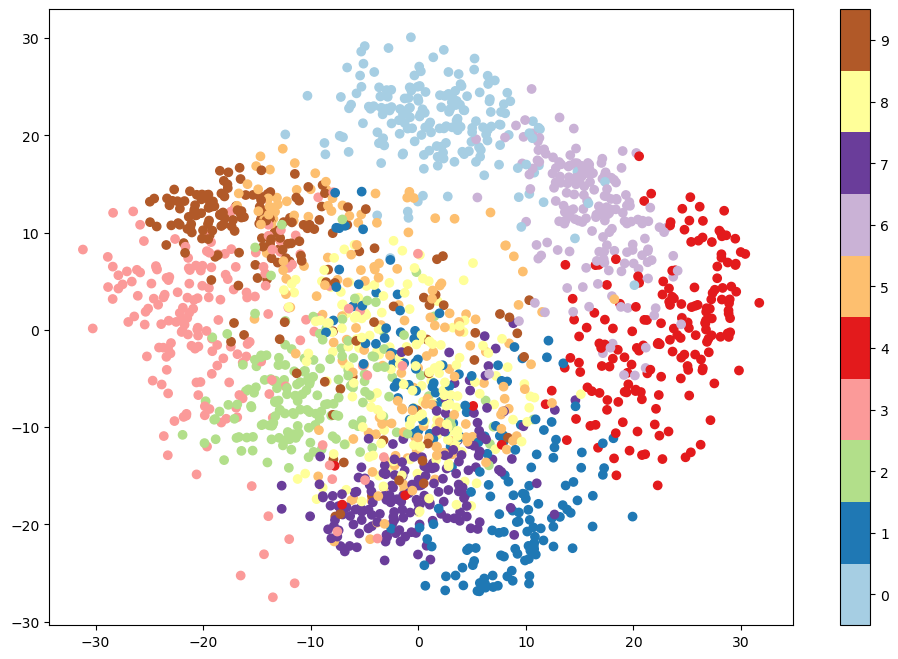

In [1]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
%matplotlib inline

digits = load_digits()
pca = PCA(n_components=2, random_state=0)
pca_digits = pca.fit_transform(digits.data)

plt.figure(figsize=(12, 8))
plt.scatter(pca_digits[:, 0], pca_digits[:, 1], c=digits.target,
            cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

#### PCA isn’t the only way to reduce a dataset to two or three dimensions for plotting. You can also use Scikit’s Isomap class or its TSNE class. TSNE implements t-distributed stochastic neighbor embedding, or t-SNE for short. t-SNE is a dimensionality reduction algorithm that is used almost exclusively for visualizing high-dimensional data. Whereas PCA uses a linear function to transform data, t-SNE uses a nonlinear transform that tends to heighten the separation between classes by keeping similar data points close together in low-dimensional space. (PCA, by contrast, focuses on keeping dissimilar points far apart.) Here’s an example that plots the Digits dataset in two dimensions after reducing it with t-SNE:

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


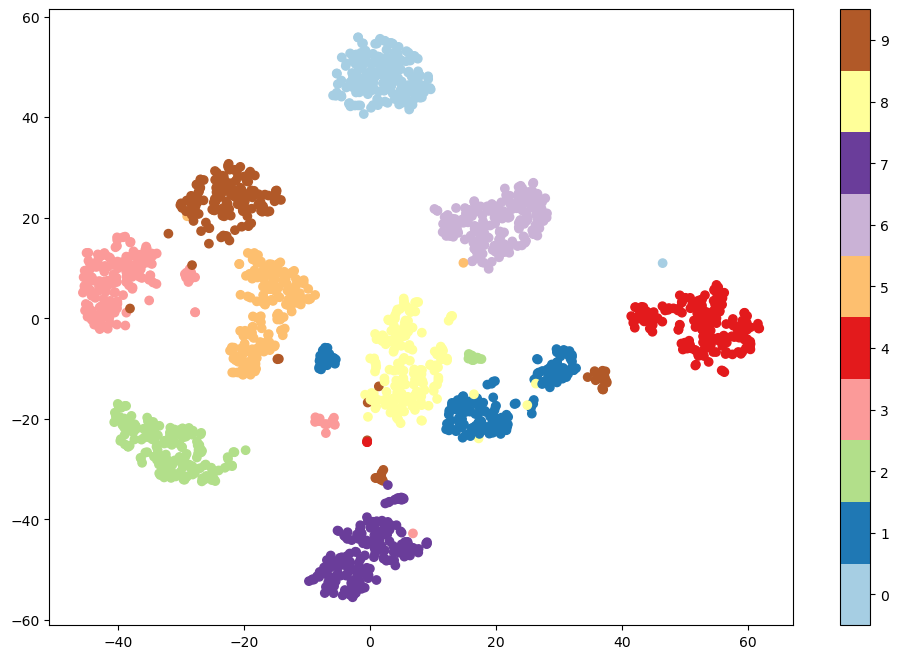

In [2]:
%matplotlib inline
from sklearn.manifold import TSNE

digits = load_digits()
tsne = TSNE(n_components=2, init='pca', learning_rate='auto',
            random_state=0)
tsne_digits = tsne.fit_transform(digits.data)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_digits[:, 0], tsne_digits[:, 1], c=digits.target,
            cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

#### t-SNE does a better job of separating groups of digits into clusters, indicating there are patterns in the data that machine learning can exploit. The chief drawback is that t-SNE is compute intensive, which means it can take a prohibitively long time to run on large datasets. One way to mitigate that is to run t-SNE on a subset of rows rather than the entire dataset. Another strategy is to use PCA to reduce the number of dimensions, and then subject the PCAed dataset to t-SNE.

## Anomaly Detection

#### There are many ways to perform anomaly detection. They go by names such as isolation forests, one-class SVMs, and local outlier factor (LOF). Most rely on unsupervised learning methods and therefore do not require labeled data. They simply look at a collection of samples and determine which ones are anomalous. Unsupervised anomaly detection is particularly interesting because it doesn’t require a priori knowledge of what constitutes an anomaly, nor does it require an unlabeled dataset to be meticulously labeled.

#### The gist of PCA-based anomaly detection is that an anomalous sample should exhibit more loss or reconstruction error (the difference between the original data and the same data after a PCA transform is applied and inverted) than a normal one. In other words, the loss incurred when an anomalous sample is PCAed and un-PCAed should be higher than the loss incurred when the same operation is applied to a normal sample. Let’s see if this assumption holds up in the real world.

In [7]:
import pandas as pd

df = pd.read_csv('/Users/maukanmir/Downloads/creditcard.csv')
df.head()

# Separate the samples by class
legit = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

# Drop the "Time" and "Class" columns
legit = legit.drop(['Time', 'Class'], axis=1)
fraud = fraud.drop(['Time', 'Class'], axis=1)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=26, random_state=0)
legit_pca = pd.DataFrame(pca.fit_transform(legit), index=legit.index)
fraud_pca = pd.DataFrame(pca.transform(fraud), index=fraud.index)

legit_restored = pd.DataFrame(pca.inverse_transform(legit_pca),
                              index=legit_pca.index)

fraud_restored = pd.DataFrame(pca.inverse_transform(fraud_pca),
                              index=fraud_pca.index)

In [9]:
import numpy as np

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

legit_scores = get_anomaly_scores(legit, legit_restored)
fraud_scores = get_anomaly_scores(fraud, fraud_restored)

<AxesSubplot:>

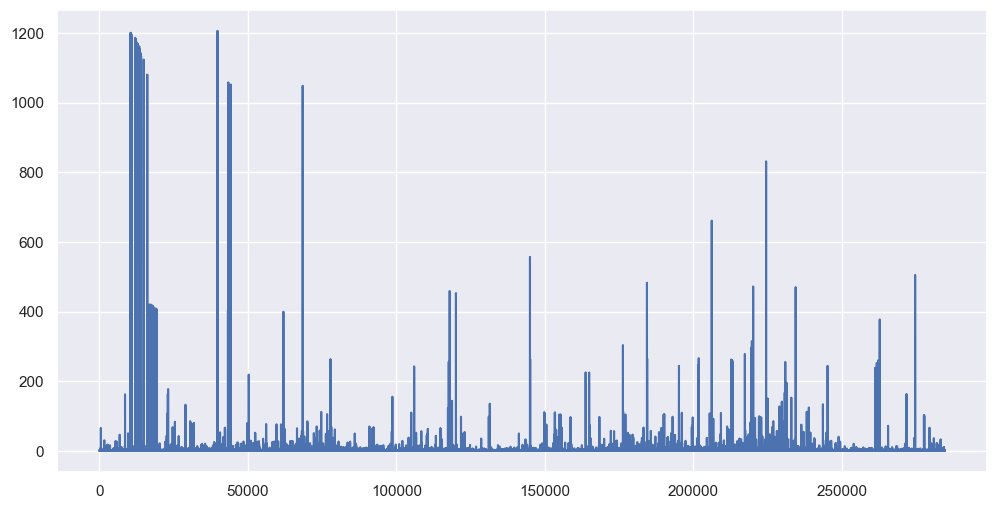

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

legit_scores.plot(figsize = (12, 6))

<AxesSubplot:>

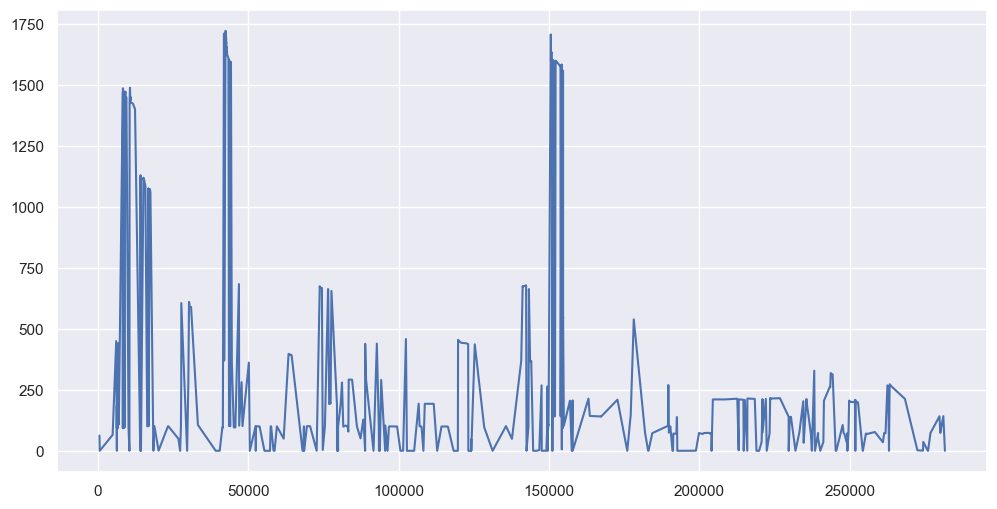

In [13]:
fraud_scores.plot(figsize = (12, 6))

Text(110.44999999999997, 0.5, 'True label')

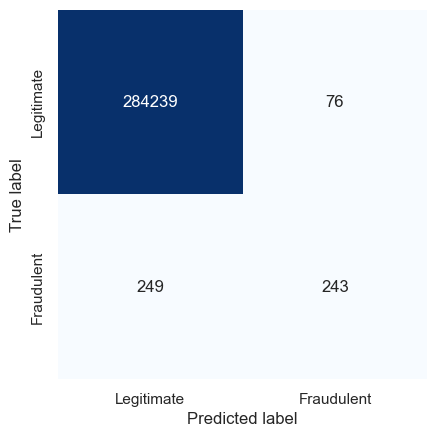

In [14]:
threshold = 200

true_neg = legit_scores[legit_scores < threshold].count()
false_pos = legit_scores[legit_scores >= threshold].count()
true_pos = fraud_scores[fraud_scores >= threshold].count()
false_neg = fraud_scores[fraud_scores < threshold].count()

labels = ['Legitimate', 'Fraudulent']
mat = [[true_neg, false_pos], [false_neg, true_pos]]

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('True label')

#### The results aren’t quite as good as they were with the random forest, but the model still caught about 50% of the fraudulent transactions while mislabeling just 76 out of 284,315 legitimate transactions. That’s an error rate of less than 0.03% for legitimate transactions, compared to 0.007% for the supervised learning model.
#### Two parameters in this model drive the error rate: the number of dimensions the datasets were reduced to (26), and the threshold chosen to distinguish between legitimate and fraudulent transactions (200). You can tweak the accuracy by experimenting with different values. I did some informal testing and concluded that this was a reasonable combination. Picking a lower threshold improves the model’s ability to identify fraudulent transactions, but at the cost of misclassifying more legitimate transactions. In the end, you have to decide what error rate you’re willing to live with, keeping in mind that declining a legitimate credit card purchase is likely to anger a customer.

In [17]:
url = 'https://raw.githubusercontent.com/jeffprosise/Practical-Machine-Learning/main/Chapter%206/Data/bearings.csv'
df = pd.read_csv(url, index_col=0, parse_dates=[0])
df.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


<AxesSubplot:>

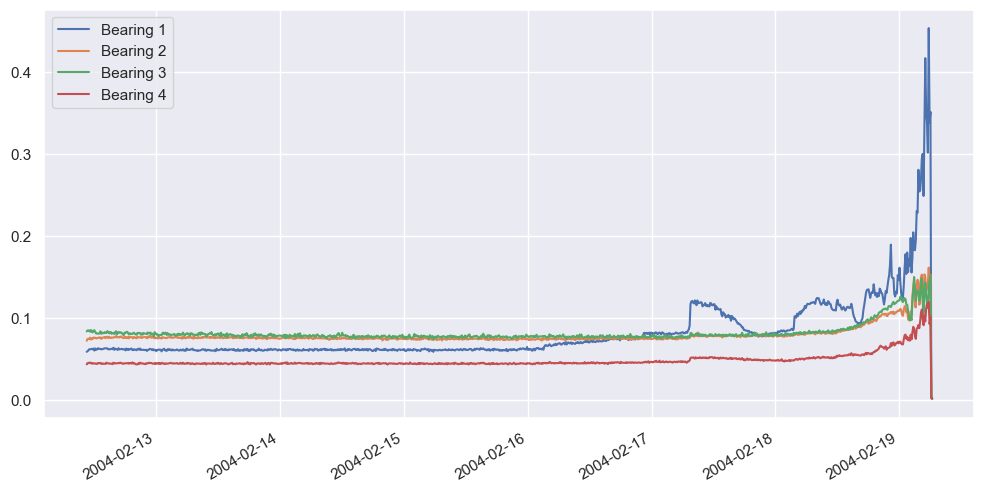

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df.plot(figsize = (12, 6))

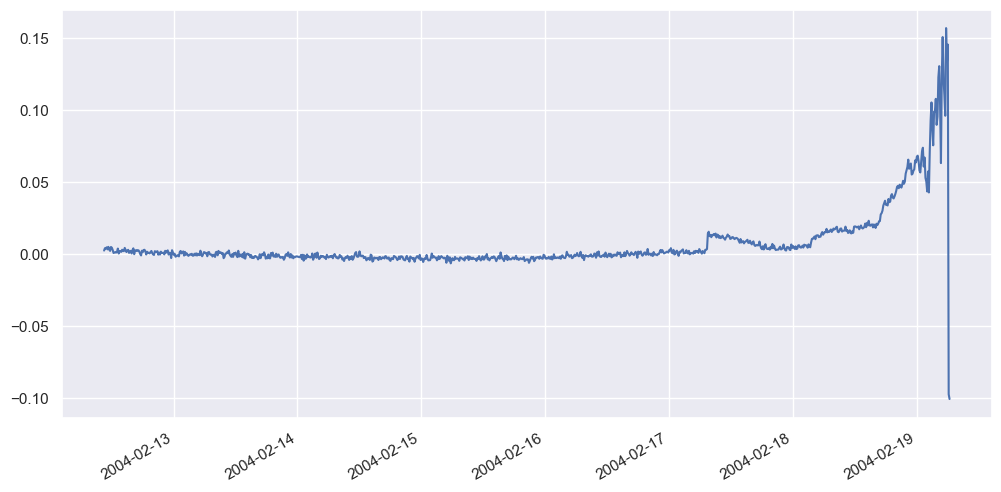

In [19]:
from sklearn.decomposition import PCA

x_train = df['2004-02-12 10:32:39':'2004-02-13 23:42:39']
x_test = df['2004-02-13 23:52:39':]

pca = PCA(n_components=1, random_state=0)
x_train_pca = pd.DataFrame(pca.fit_transform(x_train))
x_train_pca.index = x_train.index

x_test_pca = pd.DataFrame(pca.transform(x_test))
x_test_pca.index = x_test.index

df_pca = pd.concat([x_train_pca, x_test_pca])
df_pca.plot(figsize = (12, 6))
plt.legend().remove()

<AxesSubplot:>

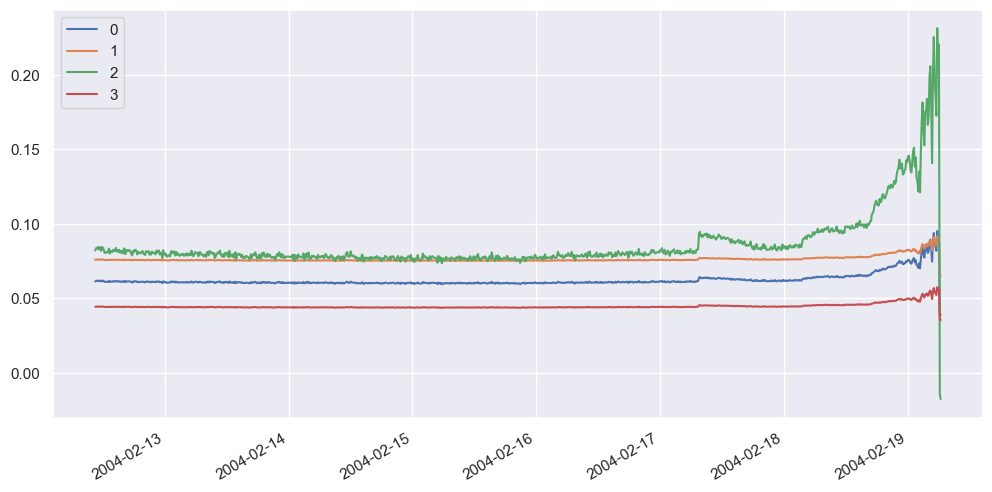

In [20]:
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)
df_restored.plot(figsize = (12, 6))

<AxesSubplot:>

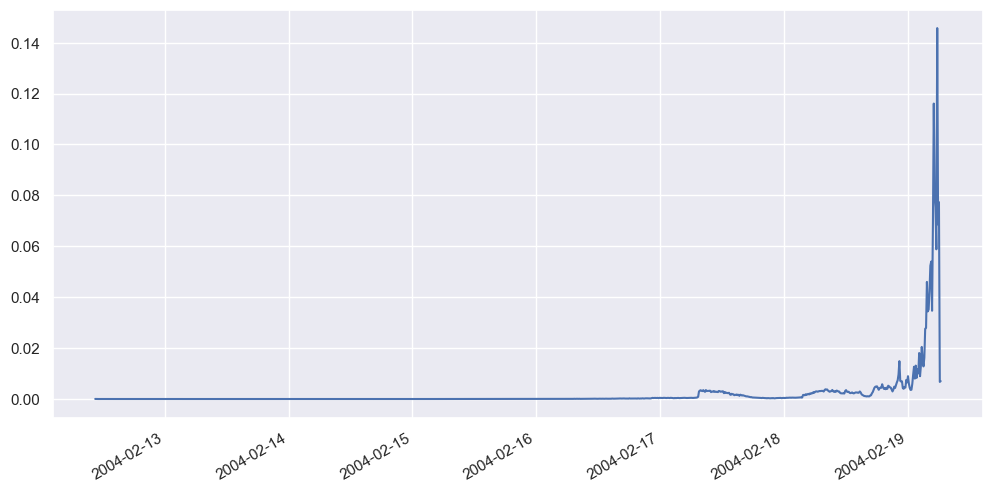

In [21]:
import numpy as np

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

scores = get_anomaly_scores(df, df_restored)
scores.plot(figsize = (12, 6))

In [22]:
def is_anomaly(row, pca, threshold):
    pca_row = pca.transform(row)
    restored_row = pca.inverse_transform(pca_row)
    losses = np.sum((row - restored_row) ** 2)
        
    for loss in losses:
        if loss > threshold:
            return True;

    return False

x = df.loc[['2004-02-16 22:52:39']]
is_anomaly(x, pca, 0.002)

False

In [23]:
x = df.loc[['2004-02-18 22:52:39']]
is_anomaly(x, pca, 0.002)

True

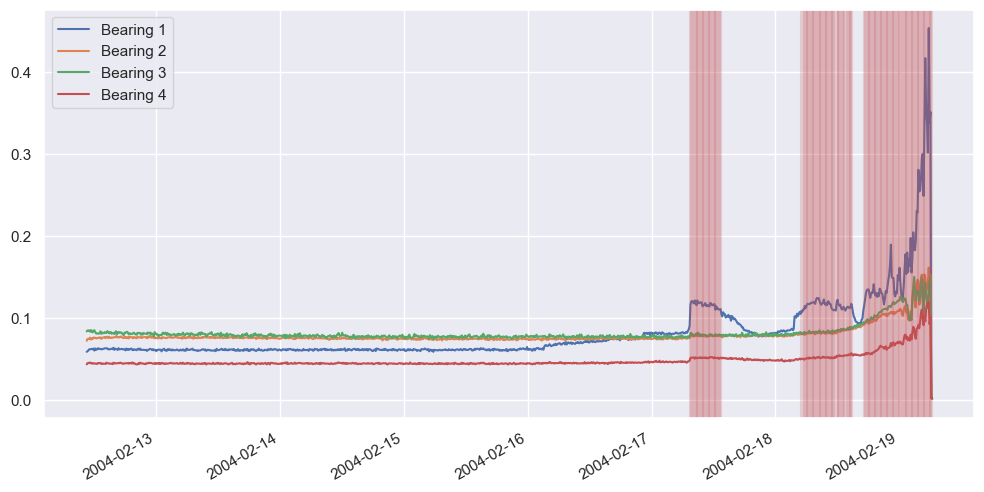

In [24]:
df.plot(figsize = (12, 6))

for index, row in df.iterrows():
    if is_anomaly(pd.DataFrame([row]), pca, 0.002):
        plt.axvline(row.name, color='r', alpha=0.2)

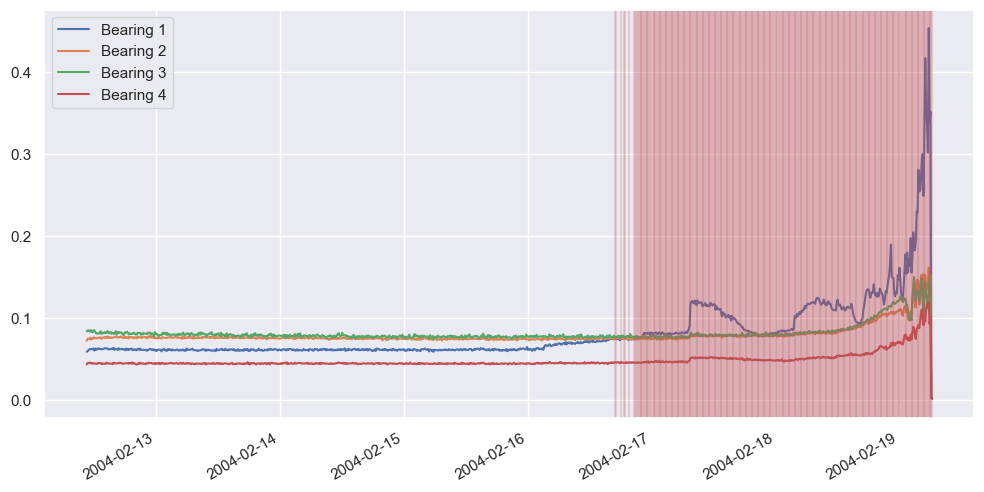

In [25]:
df.plot(figsize = (12, 6))

for index, row in df.iterrows():
    if is_anomaly(pd.DataFrame([row]), pca, 0.0002):
        plt.axvline(row.name, color='r', alpha=0.2)

#### You can adjust the sensitivity of the model by adjusting the threshold value used to detect anomalies. Using a loss threshold of 0.002 predicts bearing failure about two days before it occurs, while a loss threshold of 0.0002 predicts the failure about three days before. You typically want to choose a loss threshold that predicts failure as early as possible without raising false alarms.